# Travel Recommendation System
This notebook integrates multiple AI techniques for travel recommendation, based on Indonesian tourism data.

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

In [304]:
# Load datasets

users_df = pd.read_csv("user.csv")
user_ratings_df = pd.read_csv("tourism_rating.csv")
tourism_places_info_df = pd.read_csv("tourism_with_id.csv")
tourism_package_df = pd.read_csv("package_tourism.csv")

#users_df = pd.read_csv("/Users/roshan_thakur/Desktop/Intro to Artificial Intelligence/Module-7-Project/Vacation-Planner-Project/Indonesia-Tourism/user.csv")
#user_ratings_df = pd.read_csv("/Users/roshan_thakur/Desktop/Intro to Artificial Intelligence/Module-7-Project/Vacation-Planner-Project/Indonesia-Tourism/tourism_rating.csv")
#tourism_places_info_df = pd.read_csv("/Users/roshan_thakur/Desktop/Intro to Artificial Intelligence/Module-7-Project/Vacation-Planner-Project/Indonesia-Tourism/tourism_with_id.csv")
#tourism_package_df = pd.read_csv("/Users/roshan_thakur/Desktop/Intro to Artificial Intelligence/Module-7-Project/Vacation-Planner-Project/Indonesia-Tourism/package_tourism.csv")

## Initial Data Viewing

In [305]:
# Returns first few rows of the dataset
users_df.head(5)

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [306]:
# Returns first few rows of the dataset
user_ratings_df.head(3)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5


In [307]:
# Returns first few rows of the dataset
tourism_places_info_df.head(3)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3


In [308]:
# Returns first few rows of the dataset
tourism_package_df.head(3)

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,NaN,NaN
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,NaN,NaN
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,NaN,NaN


# Data Cleaning & Preparation

In [309]:
# Drop unused columns
tourism_places_info_df = tourism_places_info_df.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
tourism_places_info_df.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [310]:
# Show the number of rows and columns in the dataset
print(f"Number of places in the datasets : {len(tourism_places_info_df.Place_Id.unique())}")
print(f"Number of users : {len(users_df.User_Id.unique())}")
print(f"The number of ratings given by the user to the dataset : {len(user_ratings_df.User_Id)}")

Number of places in the datasets : 437
Number of users : 300
The number of ratings given by the user to the dataset : 10000


In [311]:
# Describe the type of data contained in the dataset
tourism_places_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [312]:
# Returns the count of missing values for each column.
tourism_places_info_df.isnull().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64

Check for missing values & data types

In [313]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [314]:
user_ratings_df.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

In [315]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [316]:
users_df.isnull().sum()

User_Id     0
Location    0
Age         0
dtype: int64

In [317]:
tourism_package_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Package         100 non-null    int64 
 1   City            100 non-null    object
 2   Place_Tourism1  100 non-null    object
 3   Place_Tourism2  100 non-null    object
 4   Place_Tourism3  100 non-null    object
 5   Place_Tourism4  66 non-null     object
 6   Place_Tourism5  39 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


In [318]:
tourism_package_df.isnull().sum()

Package            0
City               0
Place_Tourism1     0
Place_Tourism2     0
Place_Tourism3     0
Place_Tourism4    34
Place_Tourism5    61
dtype: int64

The columns Place_Tourism4 and Place_Tourism5 in the tourism_package_df represent optional places in a tour package. Since not all
packages include 4 or 5 places — so some values are NaN. But it’s not a problem since packages may contain any number of places.

In [319]:
# Replace the missing values with 'None'
tourism_package_df.fillna("None", inplace=True)

In [320]:
# Identify the unique categories of tourism places
tourism_places_info_df.Category.unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

In [321]:
tourism_package_df.head(5)

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,None,None
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,None,None
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,None,None
3,4,Jakarta,Pulau Tidung,Pulau Bidadari,Pulau Pari,Pulau Pramuka,Pulau Pelangi
4,5,Jakarta,Museum Satria Mandala,Museum Wayang,Museum Bahari Jakarta,Museum Macan (Modern and Contemporary Art in N...,None


## Data Preprocessing

Joining the data together and translating to english (where applicable).

In [322]:
# Data Preprocessing
## tourism_unique will be a sorted array of all unique Place IDs that exist in either tourism_places_info_df or user_ratings_df

tourism_unique_df = np.concatenate((
    tourism_places_info_df.Place_Id.unique(),
    user_ratings_df.Place_Id.unique()
))

tourism_unique_df = np.sort(np.unique(tourism_unique_df))

print(f"Total number of tourism: {len(tourism_unique_df)}")


Total number of tourism: 437


In [323]:
all_users_ratings_df = user_ratings_df
all_users_ratings_df.head(5)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [324]:
# Performs a left join
# Merge all_users_ratings_df with tourism_places_info_df based on Place_Id column, which should exist in both DataFrames.
# Keep all rows from all_user_ratings and add matching information from tourism_places_info_df
# If a match isn’t found, those new columns (Place_Name, etc.) will have NaN

tourism_combined_df = pd.merge(
    all_users_ratings_df,
    tourism_places_info_df[["Place_Id", "Place_Name", "Description", "City", "Category", "Price"]],
    on = 'Place_Id',
    how = 'left'
)
tourism_combined_df.head(5)

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,City,Category,Price
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya,75000
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari,3000
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan,94000
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya,10000
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya,0


In [325]:
# Confirm the merge was successful, inspect data health
tourism_combined_df.info()
tourism_combined_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        10000 non-null  int64 
 1   Place_Id       10000 non-null  int64 
 2   Place_Ratings  10000 non-null  int64 
 3   Place_Name     10000 non-null  object
 4   Description    10000 non-null  object
 5   City           10000 non-null  object
 6   Category       10000 non-null  object
 7   Price          10000 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 625.1+ KB


User_Id          0
Place_Id         0
Place_Ratings    0
Place_Name       0
Description      0
City             0
Category         0
Price            0
dtype: int64

In [326]:
# This creates a new column called 'city_category' in the tourism_combined_df dataFrame by combining the values in the 'City' and 'Category' columns.
# It's useful for grouping, visualization, or text-based filtering. You might use 'city_category' in a TF-IDF model, or to create tags for search or recommendation
# tourism_combined_df['city_category'] = tourism_combined_df[['City','Category']].agg(' '.join,axis=1)
# tourism_combined_df.head(5)

tourism_combined_df[tourism_combined_df['Place_Id'].duplicated(keep=False)]


,User_Id,Place_Id,Place_Ratings,Place_Name,Description,City,Category,Price
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya,75000
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari,3000
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan,94000
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya,10000
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya,0
...,...,...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Waterpark Kenjeran Surabaya merupakan wisata k...,Surabaya,Taman Hiburan,35000
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Jakarta,Budaya,2000
9997,300,311,3,The Lodge Maribaya,The Lodge Maribaya adalah salah satu tempat wi...,Bandung,Cagar Alam,25000
9998,300,279,4,Masjid Agung Trans Studio Bandung,Masjid Agung Trans Studio Bandung (TSB) berdir...,Bandung,Tempat Ibadah,0


In [327]:
# Checking for duplicate entries of place_id
duplicate_counts = tourism_combined_df['Place_Id'].value_counts()
duplicates_only = duplicate_counts[duplicate_counts > 1]
print(duplicates_only)

Place_Id
177    39
298    39
437    38
201    37
208    36
       ..
394    13
72     13
124    13
51     12
175    12
Name: count, Length: 437, dtype: int64


In [328]:
# Remove duplicate entries
#tourism_cleaned_df = tourism_combined_df.drop_duplicates("Place_Id")
#tourism_cleaned_df.head(5)

In [329]:
# Next lets restructure the dataset to make it easier to work with for our purposes

# Convert columns to lists
place_id = tourism_cleaned_df.Place_Id.tolist()
place_name = tourism_cleaned_df.Place_Name.tolist()
place_category = tourism_cleaned_df.Category.tolist()
place_desc = tourism_cleaned_df.Description.tolist()
user_ratings = tourism_cleaned_df.Place_Ratings.tolist()
city = tourism_cleaned_df.City.tolist()
#city_category = tourism_cleaned_df.city_category.tolist()
price = tourism_cleaned_df.Price.tolist()

In [330]:
#Build a new cleaned DataFrame

tourism_final_df = pd.DataFrame({
    "place_id": place_id,
    "place_name": place_name,
    "category": place_category,
    "description": place_desc,
    "ratings": user_ratings,
    "city": city,
   # "city_category": city_category,
    "price": price
})
tourism_final_df

,place_id,place_name,category,description,ratings,city,price
0,179,Candi Ratu Boko,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,3,Yogyakarta,75000
1,344,Pantai Marina,Bahari,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",2,Semarang,3000
2,5,Atlantis Water Adventure,Taman Hiburan,Atlantis Water Adventure atau dikenal dengan A...,5,Jakarta,94000
3,373,Museum Kereta Ambarawa,Budaya,Museum Kereta Api Ambarawa (bahasa Inggris: In...,3,Semarang,10000
4,101,Kampung Wisata Sosro Menduran,Budaya,Kampung wisata Sosromenduran merupakan kampung...,4,Yogyakarta,0
...,...,...,...,...,...,...,...
432,370,Benteng Pendem,Budaya,Benteng Pendem Cilacap (bahasa Belanda: Kustba...,1,Semarang,5000
433,350,Pantai Cipta,Bahari,Pantai Cipta juga dikenal sebagai Pantai Petik...,4,Semarang,5000
434,10,Pulau Tidung,Bahari,Pulau Tidung adalah salah satu kelurahan di ke...,2,Jakarta,150000
435,7,Kebun Binatang Ragunan,Cagar Alam,Kebun Binatang Ragunan adalah sebuah kebun bin...,4,Jakarta,4000


In [331]:
#Translate original Indonesian language into standard English category names

tourism_final_df["category"] = tourism_final_df["category"].replace({
    "Taman Hiburan": "Amusement Park",
    "Budaya": "Culture",
    "Cagar Alam": "National Park",
    "Bahari": "Marine Tourism",
    "Pusat Perbelanjaan": "Shopping Center",
    "Tempat Ibadah": "Temple"
})
tourism_final_df.head(5)

,place_id,place_name,category,description,ratings,city,price
0,179,Candi Ratu Boko,Culture,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,3,Yogyakarta,75000
1,344,Pantai Marina,Marine Tourism,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",2,Semarang,3000
2,5,Atlantis Water Adventure,Amusement Park,Atlantis Water Adventure atau dikenal dengan A...,5,Jakarta,94000
3,373,Museum Kereta Ambarawa,Culture,Museum Kereta Api Ambarawa (bahasa Inggris: In...,3,Semarang,10000
4,101,Kampung Wisata Sosro Menduran,Culture,Kampung wisata Sosromenduran merupakan kampung...,4,Yogyakarta,0


In [332]:
tourism_final_df['category'].unique()

array(['Culture', 'Marine Tourism', 'Amusement Park', 'National Park',
       'Shopping Center', 'Temple'], dtype=object)

In [333]:
# DATA EXPLORATORY ANALYSIS

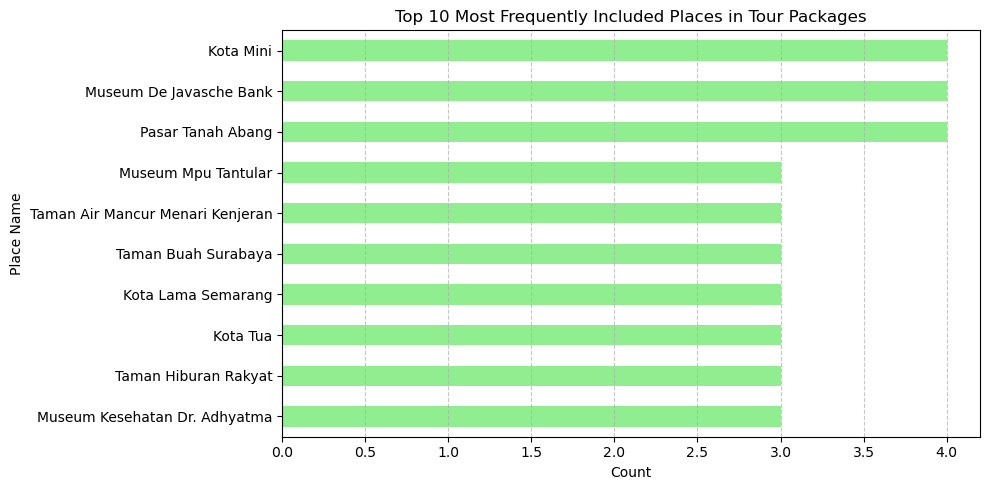

In [334]:
# Identify place columns
place_columns = [col for col in tourism_package_df.columns if "Place_Tourism" in col]
#print(place_columns)
# Clean missing values before counting
all_places_cleaned = pd.Series(tourism_package_df[place_columns].values.ravel()).dropna()
all_places_cleaned = all_places_cleaned[all_places_cleaned != "None"]

# Count top places
place_counts = all_places_cleaned.value_counts().head(10)

# Summary statistics
place_stats = {
    "Total Packages": len(tourism_package_df),
    "Total Unique Places Across Packages": len(all_places_cleaned),
    "Average Places Per Package": tourism_package_df[place_columns].notna().sum(axis=1).mean()
}

#place_stats, place_counts
# Create a bar chart of top 10 most frequent places
plt.figure(figsize=(10, 5))
place_counts.sort_values().plot(kind='barh', color='lightgreen')
plt.title("Top 10 Most Frequently Included Places in Tour Packages")
plt.xlabel("Count")
plt.ylabel("Place Name")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

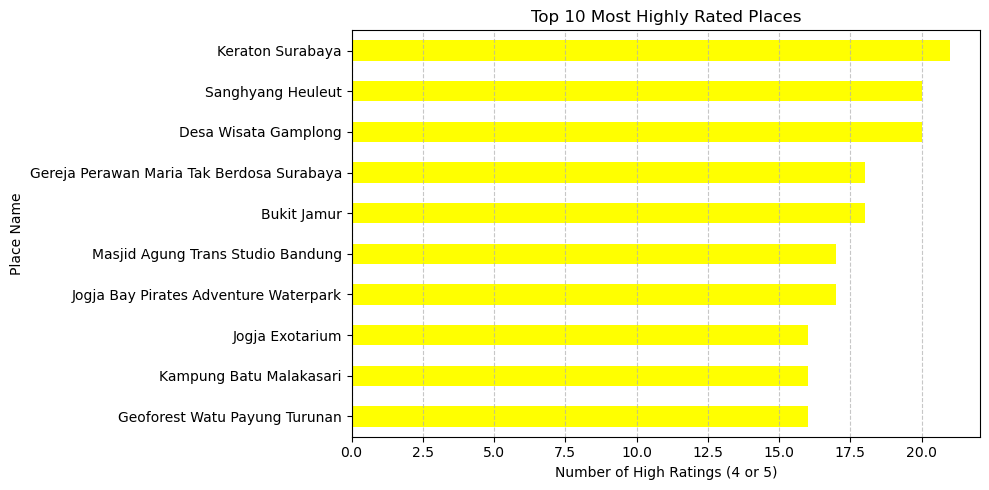

In [335]:
# Filter high ratings
high_rated_cities_df = tourism_combined_df[tourism_combined_df["Place_Ratings"] >= 4]
# Count top 10 most frequently high-rated places
high_rated_cities_count = high_rated_cities_df["Place_Name"].value_counts().head(10)

# Plot bar chart
plt.figure(figsize=(10, 5))
high_rated_cities_count.sort_values(ascending=True).plot(kind="barh", color="yellow")
plt.title("Top 10 Most Highly Rated Places")
plt.xlabel("Number of High Ratings (4 or 5)")
plt.ylabel("Place Name")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

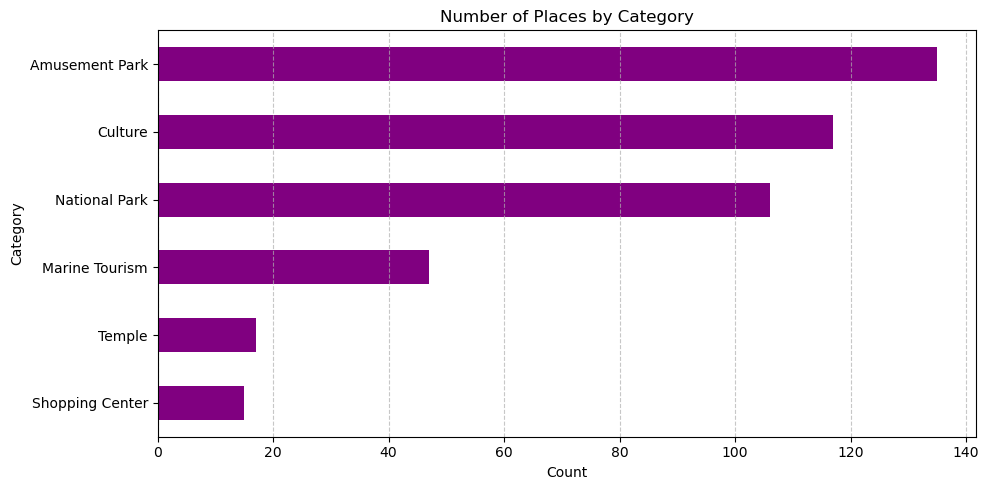

In [336]:
# Count and plot top categories
category_counts = tourism_final_df["category"].value_counts().head(10)

plt.figure(figsize=(10, 5))
category_counts.sort_values().plot(kind='barh', color='purple')
plt.title("Number of Places by Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

## CONTENT BASED RECOMMENDER

In [337]:
#users_df = pd.read_csv("user.csv")
#user_ratings_df = pd.read_csv("tourism_rating.csv")
#tourism_places_info_df = pd.read_csv("tourism_with_id.csv")
#tourism_package_df = pd.read_csv("package_tourism.csv")

# Step 1: Load and clean the tourism dataset
tourism_final_df["description"] = tourism_final_df["description"].fillna("")
tourism_final_df["place_name"] = tourism_final_df["place_name"].str.lower()

# Step 2: Define basic Indonesian stopwords (you can expand this list)
indonesian_stopwords = [
    "dan", "di", "ke", "yang", "untuk", "dengan", "ini", "itu",
    "pada", "juga", "adalah", "atau", "dari", "sebagai", "oleh", "akan"
]

# Step 3: Prepare TF-IDF matrix with Indonesian stopwords
tfidf_vectorizer = TfidfVectorizer(stop_words=indonesian_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(tourism_final_df["description"])

# Unified content-based recommender, unified since the place can be recommended based on user_id or place_name
def unified_content_recommender(user_id=None, place_name=None, top_n=5):
    if user_id is not None:
       
        high_rated = user_ratings_df[(user_ratings_df["User_Id"] == user_id) & (user_ratings_df["Place_Ratings"] >= 4)]
        if high_rated.empty:
            return f"No high-rated places found for user {user_id}."
        
        liked_places = pd.merge(high_rated, tourism_final_df, left_on="Place_Id", right_on="place_id")
        liked_indices = tourism_final_df[tourism_final_df["place_id"].isin(liked_places["place_id"])].index

        similarities = cosine_similarity(tfidf_matrix, tfidf_matrix[liked_indices])
        tourism_final_df["SimilarityScore"] = similarities.mean(axis=1)
        
        rated_place_ids = high_rated["Place_Id"]
        #Creating a dataframe "recommendations" that includes only unseen/unrated places(avoid the ones users have
        #already visited and rated)
        recommendations = tourism_final_df[~tourism_final_df["place_id"].isin(rated_place_ids)].copy()

        '''
        #Computes a new column called "recommendation_score" for each recommended place and it’s a mix of two scores.
        #We’re trying to recommend the best places to visit for someone. To decide what places are best, we look at two things:
        #How similar the place is to what the person already liked (that's called SimilarityScore). 70% of the score is based
        #on how similar this place is to the places the user liked.
        #How much everyone else liked the place (that's the overall ratings).
        #30% is based on how well-rated the place is overall (dividing by 5 makes it a score out of 1)
       '''
        
        recommendations["recommendation_score"] = (
        0.7 * recommendations["SimilarityScore"] +
        0.3 * (recommendations["ratings"] / 5.0)  # Normalize rating to 0–1
        )
        
        top_recommendations = recommendations.sort_values(by="recommendation_score", ascending=False).head(top_n)
        print(f"Recommendation list for: User {user_id}")
        print("=" * 60)
        print("\n------------------------------------------------------------")
        print("PLACES WITH HIGHEST RATING FROM THE USER:")
        print("------------------------------------------------------------")

        liked_df = liked_places.sort_values(by="Place_Ratings", ascending=False)[["place_name", "category"]]

        # Capitalize place names
        liked_df["place_name"] = liked_df["place_name"].str.title()

        # Optional: rename columns for display
        liked_df.columns = ["Place Name", "Category"]
        
        # To ensure ttat the index doesn't show as an unnamed column
        liked_df.reset_index(drop=True, inplace=True)
        display(liked_df)

        print("\n------------------------------------------------------------")
        print(f"TOP {top_n} PLACE RECOMMENDATIONS")
        print("------------------------------------------------------------")

        # Create DataFrame
        df_output_userId = pd.DataFrame({
            "Place Name": top_recommendations["place_name"].str.title(),
            "Category": top_recommendations["category"],
            "Entrance Fee": top_recommendations["price"].astype(int),
            "Rating": top_recommendations["ratings"].round(1),
            "Similarity Score": top_recommendations["SimilarityScore"].round(2)
        }).reset_index(drop=True)
        
        display(df_output_userId)
        return ""
        
    #unified content-based recommender to find places similar to a given place name 
    elif place_name:
        place_name = place_name.lower()
        # Check if the place exists
        if place_name not in tourism_final_df["place_name"].values:
            return f"'{place_name}' NOT FOUND IN DATASET. PLEASE PROVIDE VALID PLACE NAME."
            
        # Get the index of the place
        index = tourism_final_df[tourism_final_df["place_name"] == place_name].index[0]
        
        #Compute cosine similarity from the place descriptions
        cosine_sim = cosine_similarity(tfidf_matrix[index], tfidf_matrix).flatten()
        # Get top similar places. Sorts similarity scores from most to least similar (excluding the place itself at index 0).
        similar_indices = cosine_sim.argsort()[::-1][1:top_n+1]
        
        #Picks the top n similar places
        top_similar = tourism_final_df.iloc[similar_indices].copy()
        
        df_output_place_name = pd.DataFrame({
            "Place Name": top_similar["place_name"].str.title(),
            "City": top_similar["city"],
            "Category": top_similar["category"],
            "Entrance Fee": top_similar["price"].astype(int),
            "Rating": top_similar["ratings"].round(1),
            "Similarity Score": cosine_sim[similar_indices].round(2)
        }).reset_index(drop=True)

        print(f"PLACES SIMILAR TO: {place_name.title()}")
        print("=" * 80)
        print("\n---------------------------------------------------------------------------------")
        display(df_output_place_name)
        return ""


    return "Please provide either a valid user_id or place_name."

## We experimented with different weights (e.g. 0.5:0.5, 0.7:0.3, 0.8:0.2) to balance content similarity and place rating.
## Our observations showed that a 0.7:0.3 split provided the best balance between personalization and popularity. So that's why we chose 
## 0.7:0.3 weights for our project. Please scroll down to review the code.

In [338]:
# Use case to find the place similar to valid place "Candi Ratu Boko"
print(unified_content_recommender(None, "Candi Ratu Boko"))

PLACES SIMILAR TO: Candi Ratu Boko

---------------------------------------------------------------------------------


,Place Name,City,Category,Entrance Fee,Rating,Similarity Score
0,Candi Ijo,Yogyakarta,Culture,5000,3,0.39
1,Candi Prambanan,Yogyakarta,Culture,50000,4,0.29
2,Candi Sewu,Yogyakarta,Culture,50000,2,0.27
3,Candi Gedong Songo,Semarang,Culture,10000,3,0.25
4,Tebing Breksi,Yogyakarta,Culture,20000,3,0.24


In [339]:
# Use case to recommend places for user_id = 9 (valid user id)
print(unified_content_recommender(user_id = 9))

Recommendation list for: User 9

------------------------------------------------------------
PLACES WITH HIGHEST RATING FROM THE USER:
------------------------------------------------------------


,Place Name,Category
0,Hutan Wisata Tinjomoyo Semarang,National Park
1,Orchid Forest Cikole,Amusement Park
2,Curug Tilu Leuwi Opat,National Park
3,Gunung Papandayan,National Park
4,Desa Wisata Sungai Code Jogja Kota,Amusement Park
5,Wisata Agro Edukatif Istana Susu Cibugary,Amusement Park
6,Jembatan Biru Ambarawa,Amusement Park
7,Surabaya Museum (Gedung Siola),Culture
8,Pantai Sadranan,Marine Tourism
9,Gunung Papandayan,National Park



------------------------------------------------------------
TOP 5 PLACE RECOMMENDATIONS
------------------------------------------------------------


,Place Name,Category,Entrance Fee,Rating,Similarity Score
0,Pantai Ria Kenjeran,Marine Tourism,15000,5,0.07
1,Pantai Kukup,Marine Tourism,10000,5,0.06
2,Situ Patenggang,National Park,20000,5,0.06
3,Pantai Ngandong,Marine Tourism,10000,5,0.05
4,Pantai Baron,Marine Tourism,10000,5,0.05


As we can see even places with low Ratings are being recommended, and the reason is 
we are using a content-based recommender, which works like this:
Recommends places that are textually similar to places the user rated highly, regardless of how others rated them.

So the model looks at description similarity and ignores the average public rating of that place.

The problem got fixed after adding the recommendation_score concept, Keeps good matches even if slightly lower rated.

In [340]:
# Use case to recommend places for user_id = 39 (valid user id)
print(unified_content_recommender(user_id = 39))

Recommendation list for: User 39

------------------------------------------------------------
PLACES WITH HIGHEST RATING FROM THE USER:
------------------------------------------------------------


,Place Name,Category
0,Skyrink - Mall Taman Anggrek,Amusement Park
1,Taman Pintar Yogyakarta,Amusement Park
2,Sunrise Point Cukul,National Park
3,Kawah Putih,National Park
4,Tirto Argo Siwarak,Amusement Park
5,Monumen Serangan Umum 1 Maret,Amusement Park
6,Saloka Theme Park,Amusement Park
7,Dusun Bambu,Amusement Park
8,Air Terjun Kali Pancur,National Park
9,Wisata Eling Bening,National Park



------------------------------------------------------------
TOP 5 PLACE RECOMMENDATIONS
------------------------------------------------------------


,Place Name,Category,Entrance Fee,Rating,Similarity Score
0,Kawah Rengganis Cibuni,National Park,5000,5,0.06
1,Taman Buah Surabaya,Amusement Park,0,5,0.06
2,Situ Patenggang,National Park,20000,5,0.06
3,Hutan Wisata Tinjomoyo Semarang,National Park,3000,5,0.05
4,Taman Sungai Mudal,National Park,10000,5,0.05


In [341]:
# Use case to recommend places for invalid place name
print(unified_content_recommender(None, "museum"))

'museum' NOT FOUND IN DATASET. PLEASE PROVIDE VALID PLACE NAME.


if user_id is not None:
    high_rated = rating_df[(rating_df["User_Id"] == user_id) & (rating_df["Place_Ratings"] >= 4)]

This code collect the user's preferences — i.e., places they rated 4 or 5 stars
Use TF-IDF embeddings of descriptions to:

Represent each place as a vector of content features
Compute cosine similarity between the user’s liked places and all other places
Score and rank unseen places based on similarity to the user's preferences

You’re using a user’s past behavior to predict new destinations they are likely to enjoy, based on content similarity.

In [342]:
# Use case to recommend places for invalid user_id
print(unified_content_recommender(user_id = 5000))

No high-rated places found for user 5000.


In [343]:
# Use case to recommend places for null user_id and place_name
print(unified_content_recommender())

Please provide either a valid user_id or place_name.


In [344]:
tourism_package_df.head(2)

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,None,None
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,None,None


## TOURISM PACKAGE RECOMMENDER ##

To recommend the top 3 tour packages to a user based on:

Places they rated highly (≥ 4 stars)
What each package contains
How well their preferences match the places in a package

Logic:
1. Looks up the user’s city from users_df and returns an error message if hte user is not found.
2. Check if user has rated any places.If no ratings exist, it selects a fallback package from the user’s city (randomly).
3. Get user's top-rated places by filtering the places the user has rated 4 or higher.Extracts names and scores of the matching places.
4. For each package, collects all places listed in Place_Tourism1 to Place_Tourism5, checks which of those match the user's liked places and computes a score by summing the ratings for matched places.
5. Display the results which includes:
    City, score, matched places, and all places in the package

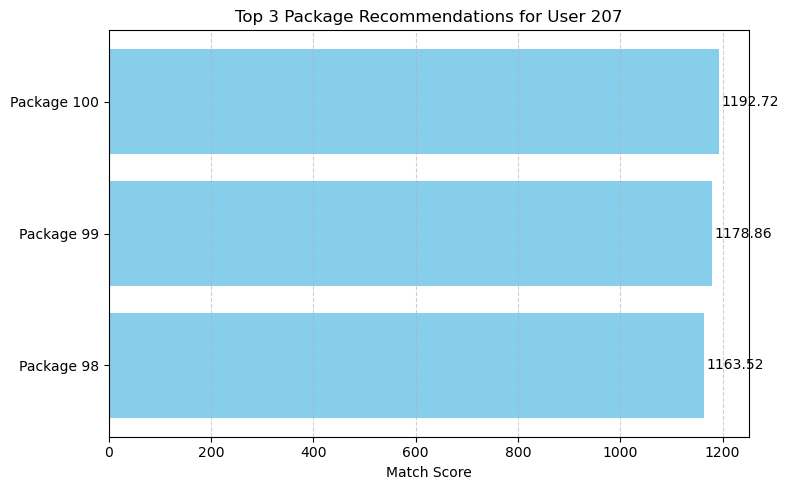

 Top 3 Package Recommendations for User 207

Package 1: 100
Package City: Surabaya
Match Score: 1192.719

Matched Places from User Ratings:
- Grand Indonesia Mall
- Tugu Proklamasi
- Taman Spathodea
- Alun-Alun Utara Keraton Yogyakarta
- Pantai Baruna
- Obyek Wisata Goa Kreo
- Pantai Baruna
- Grand Indonesia Mall
- Tugu Proklamasi
- Taman Spathodea
- Alun-Alun Utara Keraton Yogyakarta
- Pantai Baruna
- Obyek Wisata Goa Kreo
- Pantai Baruna

All Places in Package:
- Taman Buah Surabaya
- Hutan Bambu Keputih
- Taman Barunawati
- Kebun Bibit Wonorejo
- Taman Mundu

Package 2: 99
Package City: Surabaya
Match Score: 1178.859

Matched Places from User Ratings:
- Grand Indonesia Mall
- Tugu Proklamasi
- Taman Spathodea
- Alun-Alun Utara Keraton Yogyakarta
- Pantai Baruna
- Obyek Wisata Goa Kreo
- Pantai Baruna
- Grand Indonesia Mall
- Tugu Proklamasi
- Taman Spathodea
- Alun-Alun Utara Keraton Yogyakarta
- Pantai Baruna
- Obyek Wisata Goa Kreo
- Pantai Baruna

All Places in Package:
- Taman E

In [345]:
#Imports the SVD algorithm and dataset handling tools from the surprise library
from surprise import SVD, Dataset, Reader

# Prepare dataset for surprise SVD model. Read in values as Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_ratings_df[["User_Id", "Place_Id", "Place_Ratings"]], reader)

# full training data
trainset = data.build_full_trainset()

# Train SVD model on full training data which learns:
#What kind of places each user prefers (latent preferences)
#Which types of users like which places
svd_model = SVD()
svd_model.fit(trainset)

# Create a map from place_name to Place_Id
place_id_map = tourism_places_info_df.set_index("Place_Name")["Place_Id"].to_dict()

# Hybrid logic-based + SVD package recommender
def tourism_package_recommender(user_id, top_n = 3):
    
    # Get user info to check if user exists
    user_info = users_df[users_df["User_Id"] == user_id]

    if user_info.empty:
        return "User not found."

    user_city = user_info.iloc[0]["Location"]
    ratings = user_ratings_df[user_ratings_df["User_Id"] == user_id]

    #If the user has never rated anything, recommend a random package from their city
    if ratings.empty:
        fallback = tourism_package_df[tourism_package_df["City"].str.lower() == user_city.lower()]
        if fallback.empty:
            return "No packages found for user's city."
        pkg = fallback.sample(1).iloc[0]
        places = [pkg[col] for col in tourism_package_df.columns if "Place_Tourism" in col and pd.notna(pkg[col])]
        #return f"Fallback package for user {user_id} (city-based):\nPackage {pkg['Package']}: " + ", ".join(places)
        return f"Fallback package for user {user_id} (city-based):\n\n📦 Package: {pkg['Package']}\n📍 City: {pkg['City']}\n🗺️ Places Included:\n- " + "\n- ".join(places)

    # If ratings exist, do logic-based scoring(Filters places the user liked and Gets full place info)
    top_rated = ratings[ratings["Place_Ratings"] >= 3.5]
    
    liked = tourism_places_info_df[tourism_places_info_df["Place_Id"].isin(top_rated["Place_Id"])]
    #place_names = liked["Place_Name"].str.lower().tolist()
    #Normalize names for matching
    place_names = liked["Place_Name"].str.strip().str.lower().tolist()
    place_scores = dict(zip(liked["Place_Name"].str.lower(), top_rated["Place_Ratings"]))
    
    package_scores, pkg_places = [], []
    # Score each package. For each package:
    for _, row in tourism_package_df.iterrows():
        #Extract all places
        # Loop through each column in the DataFrame
        for col in tourism_package_df.columns:
            # Check if the column name contains 'Place_Tourism' and the value is not empty
            if "Place_Tourism" in col and pd.notna(row[col]):
                # Get the place name, remove extra spaces, and convert to lowercase
                place_name = str(row[col]).strip().lower()
                # Add it to the list
                pkg_places.append(place_name)
        
        # Check how many match the user's liked places
        matched = [p for p in pkg_places if p in place_names]
        # Add up the user's ratings to get a match score
        score = sum(place_scores[p] for p in matched)

        for p in pkg_places:
            if p in place_scores:
                score += place_scores[p]  # Real rating
                matched.append(p)
            elif p.title() in place_id_map:
                # SVD-predicted rating
                place_id = place_id_map[p.title()]
                predicted_rating = svd_model.predict(user_id, place_id).est
                score += predicted_rating  # You could scale this with weight if needed

        if score > 0:
            package_scores.append({
                "Package": row["Package"],
                "City": row["City"],
                "Score": round(score,3),
                "Matched Places": matched,
                "All Places": [str(row[col]) for col in tourism_package_df.columns if "Place_Tourism" in col and pd.notna(row[col]) and str(row[col]).lower() != "none"]
            })

    if not package_scores:
        return "No matching package found."

    sorted_packages = sorted(package_scores, key=lambda x: x["Score"], reverse=True)[:top_n]
    
    outputs = [f" Top {top_n} Package Recommendations for User {user_id}\n{'='*60}"]
    for i, pkg in enumerate(sorted_packages, start=1):
        outputs.append(
        
            f"\n\033[1mPackage {i}:\033[0m {pkg['Package']}\n"
            f"\033[1mPackage City:\033[0m {pkg['City']}\n"
            f"\033[1mMatch Score:\033[0m {pkg['Score']}\n"
            f"\n\033[1mMatched Places from User Ratings:\033[0m\n- " + "\n- ".join(p.title() for p in pkg["Matched Places"]) +
            f"\n\n\033[1mAll Places in Package:\033[0m\n- " + "\n- ".join(p.title() for p in pkg["All Places"]),
        )

    # Collect names and scores from sorted_packages
    package_names = [f"Package {pkg['Package']}" for pkg in sorted_packages]
    match_scores = [pkg["Score"] for pkg in sorted_packages]

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(package_names, match_scores, color="skyblue")
    plt.xlabel("Match Score")
    plt.title(f"Top {top_n} Package Recommendations for User {user_id}")
    plt.gca().invert_yaxis()

    # Add score labels to each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 5, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

    return "\n".join(outputs)

# Run the enhanced recommender for user 10
#print(tourism_package_recommender(user_id = 10))
#print(tourism_package_recommender(user_id = 109))
#print(tourism_package_recommender(user_id = 36))
#print(tourism_package_recommender(user_id = 3098776556))
print(tourism_package_recommender(user_id = 207))


## EXPERIMENT WITH DIFFERENT WEIGHTS..CONTINUATION FROM ABOVE...

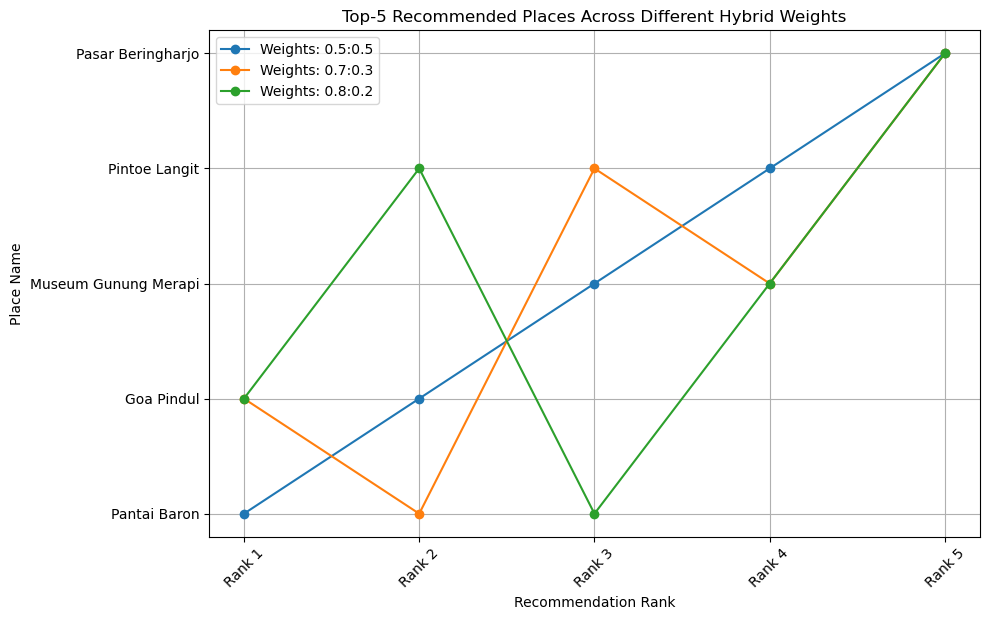

In [346]:
# Re-import after code execution state reset

# Simulated recommendation data for 3 different weight combinations
data = {
    "0.5:0.5": ["Pantai Baron", "Goa Pindul", "Museum Gunung Merapi", "Pintoe Langit", "Pasar Beringharjo"],
    "0.7:0.3": ["Goa Pindul", "Pantai Baron", "Pintoe Langit", "Museum Gunung Merapi", "Pasar Beringharjo"],
    "0.8:0.2": ["Goa Pindul", "Pintoe Langit", "Pantai Baron", "Museum Gunung Merapi", "Pasar Beringharjo"]
}

# Convert to DataFrame
df_compare = pd.DataFrame(data)
df_compare.index = [f"Rank {i+1}" for i in range(5)]

# Plot
plt.figure(figsize=(10, 6))
for column in df_compare.columns:
    plt.plot(df_compare.index, df_compare[column], marker='o', label=f"Weights: {column}")

plt.title("Top-5 Recommended Places Across Different Hybrid Weights")
plt.xlabel("Recommendation Rank")
plt.ylabel("Place Name")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()